In [26]:
import os
import cv2
import time
import string
import random
import numpy as np
import collections
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
folder = "drive/MyDrive/images_for_sign_reading"

filenames = []

for file in os.listdir(folder):
  filenames.append(file)

filenames.sort()
filenames = filenames[3:]
filenames[0:4]

['image_20250316_155643_957192_Road_Lin_0.97_Ang_-0.00.png',
 'image_20250316_155644_224541_Road_Lin_0.97_Ang_-0.00.png',
 'image_20250316_155644_487286_Road_Lin_0.97_Ang_-0.00.png',
 'image_20250316_155644_753888_Road_Lin_0.97_Ang_-0.57.png']

In [ ]:
# folder = "drive/MyDrive/images_for_sign_reading"
# template_img = cv2.imread(folder + "/full_sign.jpg")

# final_size = (2400, 1400)  # width x height
# downscaled_template = cv2.resize(template_img, final_size, interpolation=cv2.INTER_AREA)

# # Save the downscaled template image
# cv2.imwrite("template_full.png", downscaled_template)
# print("Saved downscaled template as 'template_full.png'")

Saved downscaled template as 'template_full.png'


In [ ]:
# save_folder = "drive/MyDrive/letter_crops"
# os.makedirs(save_folder, exist_ok=True)

# Image generation and labelling

In [ ]:
# setup object detection
sift = cv2.SIFT_create()
index_params = dict(algorithm=0, trees=5)
search_params = dict()
flann = cv2.FlannBasedMatcher(index_params, search_params)

In [ ]:
def detection(i, filename):
    ''' SIFT PART '''

    # import images
    template_img_bgr = cv2.imread(folder + "/full_sign.jpg")
    query_img_bgr = cv2.imread(folder + "/" + filename)

    template_img = cv2.cvtColor(template_img_bgr, cv2.COLOR_BGR2GRAY)
    query_img = cv2.cvtColor(query_img_bgr, cv2.COLOR_BGR2GRAY)

    # scale images
    scale_template = 0.4
    scale_query = 0.4
    downscaled_template = cv2.resize(template_img, None, fx=scale_template, fy=scale_template, interpolation=cv2.INTER_AREA)
    downscaled_query = cv2.resize(query_img, None, fx=scale_query, fy=scale_query, interpolation=cv2.INTER_AREA)

    # SIFT
    start_sift = time.time()
    keypoints1, descriptors1 = sift.detectAndCompute(downscaled_template, None)
    keypoints2, descriptors2 = sift.detectAndCompute(downscaled_query, None)
    end_sift = time.time()

    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    good_matches = [m for m, n in matches if m.distance < 0.7 * n.distance]
    MIN_MATCH_COUNT = 20

    # warp image
    if len(good_matches) <= MIN_MATCH_COUNT:
        return end_sift - start_sift

    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    H, _ = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)

    if H is None or H.shape != (3, 3):
        return end_sift - start_sift

    S_query = np.array([[scale_query, 0, 0], [0, scale_query, 0], [0, 0, 1]], dtype=np.float32)
    S_template_inv = np.array([[1/scale_template, 0, 0], [0, 1/scale_template, 0], [0, 0, 1]], dtype=np.float32)
    H_original_scale = S_template_inv @ H @ S_query

    warped_img = cv2.warpPerspective(query_img_bgr, H_original_scale, (template_img.shape[1], template_img.shape[0]))

    #TODO: check if white frame surrounds fully on all sides
    #TODO: determine if warp is 'good' or 'bad'

    ''' CROPPING PART '''

    # threshold by searching for blue
    hsv = cv2.cvtColor(warped_img, cv2.COLOR_BGR2HSV)
    lower_blue = np.array([100, 150, 50])
    upper_blue = np.array([130, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)

    # clean up cracks and gaps
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    mask_cleaned = cv2.morphologyEx(blue_mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    # flood fill to get rid of the white surrounding frame starting at (10,10)
    flood_filled = mask_cleaned.copy()
    cv2.floodFill(flood_filled, None, (10, 10), 0)

    #TODO: crop image in half, pass top half into CNN, bottom half keep processing

    # find connected components
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(flood_filled, connectivity=4)

    # filter connected component blobs
    min_area = 300
    letter_boxes = []
    for label in range(1, num_labels):  # skip label 0 (background)
        x, y, w, h, area = stats[label]
        if area >= min_area:
            letter_boxes.append((x, y, w, h))

    # sort in order top and bottom, and left to right
    img_height = flood_filled.shape[0]
    top_half = []
    bottom_half = []

    for box in letter_boxes:
        x, y, w, h = box
        center_y = y + h // 2
        if center_y < img_height / 2:
            top_half.append(box)
        else:
            bottom_half.append(box)

    top_half = sorted(top_half, key=lambda b: b[0])
    bottom_half = sorted(bottom_half, key=lambda b: b[0])
    letter_boxes = top_half + bottom_half

    # plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(downscaled_query, cmap='gray')
    plt.title("Downscaled Query")

    plt.subplot(1, 5, 2)
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    plt.title("Warped Image")

    debug_img = cv2.cvtColor(flood_filled, cv2.COLOR_GRAY2BGR)
    for (x, y, w, h) in letter_boxes:
        cv2.rectangle(debug_img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    plt.subplot(1,5,3)
    plt.imshow(mask_cleaned,  cmap='gray')
    plt.title("Thresholded and Cleaned")

    plt.subplot(1,5,4)
    plt.imshow(flood_filled,  cmap='gray')
    plt.title("Flood Filled")

    plt.subplot(1, 5, 5)
    plt.imshow(debug_img)
    plt.title("Detected Letters")
    plt.axis('off')
    plt.show()

    # crop/pad all boxes to the same size
    target_width = 200
    target_height = 240

    letter_crops = []

    for (x, y, w, h) in letter_boxes:
        crop = flood_filled[y:y+h, x:x+w]

        if h > target_height or w > target_width:
            crop = cv2.resize(crop, (min(w, target_width), min(h, target_height)), interpolation=cv2.INTER_AREA)
            h, w = crop.shape

        pad_top = (target_height - h) // 2
        pad_bottom = target_height - h - pad_top
        pad_left = (target_width - w) // 2
        pad_right = target_width - w - pad_left

        padded_crop = cv2.copyMakeBorder(
            crop,
            top=pad_top, bottom=pad_bottom,
            left=pad_left, right=pad_right,
            borderType=cv2.BORDER_CONSTANT,
            value=0
        )

        letter_crops.append(padded_crop)

    # Plot each cropped letter
    if len(letter_crops) > 0:
        for idx, crop in enumerate(letter_crops):
            save_path = os.path.join(save_folder, f"{i}{idx}.png")
            cv2.imwrite(save_path, crop)

        cols = min(10, len(letter_crops))
        rows = int(np.ceil(len(letter_crops) / cols))
        fig, axs = plt.subplots(rows, cols, figsize=(2*cols, 2*rows))

        if rows == 1:
            axs = np.expand_dims(axs, axis=0)

        for idx, crop in enumerate(letter_crops):
            r, c = divmod(idx, cols)
            axs[r][c].imshow(crop, cmap='gray')
            axs[r][c].axis('off')

        for i in range(len(letter_crops), rows * cols):
            r, c = divmod(i, cols)
            axs[r][c].axis('off')

        plt.suptitle("Extracted Letters", fontsize=16)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Frame {i}: No letters detected.")

    return end_sift - start_sift


In [ ]:
print(len(filenames))

261


In [ ]:
n = 80
random_filenames = random.sample(filenames, n)
total_time = 0.0

for i, filename in enumerate(random_filenames):
    total_time = total_time + detection(i, filename)

print("AVERAGE SIFT TIME: ", total_time/n)

# Import labelled images

In [27]:
image_folder = "/home/fizzer/ros_ws/training_for_reading/letter_crops"

image_filenames = []

for file in os.listdir(image_folder):
  image_filenames.append(file)

image_filenames.sort()
image_filenames[0:4]

['A_001.png', 'A_002.png', 'A_003.png', 'A_004.png']

In [28]:
print(f"Number of unique image files: {len(set(image_filenames))}")

Number of unique image files: 275


In [29]:
full_dataset_images = []
full_dataset_labels = []

datagen = ImageDataGenerator(
    rotation_range=4,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    fill_mode='nearest'
)

extra_labels = {
    3: 4,  5: 2,  6: 2,  7: 4,  9: 10, #d, f, g, h, j
    10: 20, 13: 2, 15: 2, 16: 20, 17: 2, #k, n, p, q, r
    18: 2, 20: 10, 21: 4, 22: 2, 24: 5, 25: 10 #s, u, v, w, y, z
}

DEFAULT_NUM = 1  # if not in extra labels

for image_filename in image_filenames:
    image_path = os.path.join(image_folder, image_filename)
    image_array = np.array(Image.open(image_path))
    image_array = np.expand_dims(image_array, axis=-1)
    image_array = np.expand_dims(image_array, axis=0)

    label = int(ord(image_filename[0]) - 65)  # A-Z to 0-25

    num_to_generate = 4*extra_labels.get(label, DEFAULT_NUM)

    datagen_iterator = datagen.flow(image_array, batch_size=1)

    for _ in range(num_to_generate):
        value = next(datagen_iterator)
        img = value[0].astype('uint8')

        full_dataset_images.append(img)
        full_dataset_labels.append(label)

print(f"Total images: {len(full_dataset_images)}")
print(f"Total labels: {len(full_dataset_labels)}")


Total images: 1880
Total labels: 1880


Unique Labels in Full Set: 24


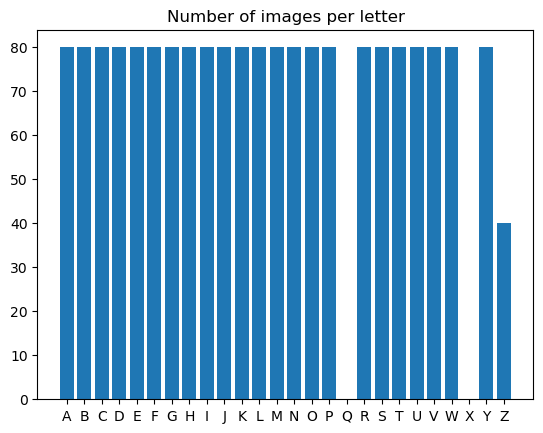

In [30]:
print("Unique Labels in Full Set:", len(np.unique(full_dataset_labels)))

counter = collections.Counter(full_dataset_labels)
plt.bar(range(26), [counter[i] for i in range(26)])
plt.xticks(range(26), [chr(i+65) for i in range(26)])
plt.title("Number of images per letter")
plt.show()

In [31]:
num_samples = len(full_dataset_images)
indices = np.arange(num_samples)
np.random.shuffle(indices)

shuffled_images = np.array(full_dataset_images)[indices]
shuffled_labels = np.array(full_dataset_labels)[indices]

# Define split percentages
train_split = 0.7
val_split = 0.15
test_split = 0.15

# Calculate split indices
train_end = int(train_split * num_samples)
val_end = train_end + int(val_split * num_samples)

# Perform the splits
train_images, train_labels = shuffled_images[:train_end], shuffled_labels[:train_end]
val_images, val_labels = shuffled_images[train_end:val_end], shuffled_labels[train_end:val_end]
test_images, test_labels = shuffled_images[val_end:], shuffled_labels[val_end:]

# Free up memory
del shuffled_images
del shuffled_labels

# Print stats
print(f"Training set: {len(train_images)} images")
print(f"Validation set: {len(val_images)} images")
print(f"Test set: {len(test_images)} images")

Training set: 1316 images
Validation set: 282 images
Test set: 282 images


13


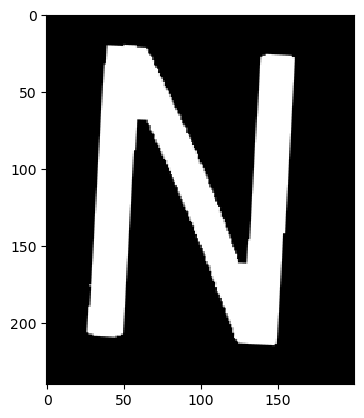

In [32]:
print(train_labels[100])
plt.imshow(train_images[100].squeeze(), cmap='gray')

In [33]:
train_images = train_images.astype(np.float32, copy=False) # convert
train_images /= 255.0  # normalize

val_images = val_images.astype(np.float32, copy=False)
val_images /= 255.0

test_images = test_images.astype(np.float32, copy=False)
test_images /= 255.0

print("Image shape:", train_images[0].shape)
print(type(train_images[0]))
print(train_images[0].dtype)

Image shape: (240, 200, 1)
<class 'numpy.ndarray'>
float32


In [34]:
print("Unique Labels in Training Set:", len(np.unique(train_labels)))
print("Unique Labels in Validation Set:",len(np.unique(val_labels)))
print("Unique Labels in Test Set:",len(np.unique(test_labels)))

Unique Labels in Training Set: 24
Unique Labels in Validation Set: 24
Unique Labels in Test Set: 24


In [35]:
from tensorflow.keras.utils import to_categorical

num_classes = 26

# convert integer labels to one-hot encoding
train_labels = to_categorical(train_labels, num_classes=num_classes)
val_labels = to_categorical(val_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

print("Train Images and Labels Shape:", train_images.shape, train_labels.shape)
print("Example One-Hot Encoded Label:\n", train_labels[0])

Train Images and Labels Shape: (1316, 240, 200, 1) (1316, 26)
Example One-Hot Encoded Label:
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


# CNN

In [68]:
# # define CNN model
model = models.Sequential([
    # Conv Block 1
    layers.Input(shape=(240, 200, 1)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Conv Block 4
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Fully Connected Layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),# Reduces overfitting
    layers.Dense(128, activation='relu'),  # Extra Dense layer
    layers.Dropout(0.5),
    layers.Dense(26, activation='softmax')# 26 classes (A-Z)
])

# compile model
LEARNING_RATE = 1e-4
model.compile(
    loss='categorical_crossentropy',
    optimizer = optimizers.Adam(learning_rate=LEARNING_RATE),
    metrics=['accuracy']
)

In [69]:
# set weights (either reset or load saved weights)
# model.set_weights(initial_weights)

#if loading a model for refining
#model =  tf.keras.models.load_model('/home/fizzer/ros_ws/training_for_reading/best_model.h5')

EPOCHS = 160
BATCH_SIZE = 16

callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=50,  # Increased from 10
            min_delta=0.00001,  # Minimum change to qualify as improvement
            mode='min',
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=7,  # Wait longer before reducing LR
            verbose=1
        ),
        tf.keras.callbacks.ModelCheckpoint(
            '/home/fizzer/ros_ws/training_for_reading/best_model.h5',
            save_best_only=True,
            save_weights_only=False,
            monitor='val_loss'
        )
    ]

history_conv = model.fit(
    train_images, train_labels,
    validation_data=(val_images, val_labels),
    epochs=EPOCHS,
    callbacks=callbacks,
    batch_size=BATCH_SIZE
)

Epoch 1/160
83/83 [==============================] - 2s 23ms/step - loss: 3.2259 - accuracy: 0.0919 - val_loss: 3.2723 - val_accuracy: 0.0496 - lr: 1.0000e-04
Epoch 2/160
83/83 [==============================] - 2s 20ms/step - loss: 2.8863 - accuracy: 0.1755 - val_loss: 3.3897 - val_accuracy: 0.0426 - lr: 1.0000e-04
Epoch 3/160
83/83 [==============================] - 2s 20ms/step - loss: 2.6439 - accuracy: 0.2508 - val_loss: 3.7497 - val_accuracy: 0.0426 - lr: 1.0000e-04
Epoch 4/160
83/83 [==============================] - 2s 20ms/step - loss: 2.4391 - accuracy: 0.2827 - val_loss: 4.1297 - val_accuracy: 0.0426 - lr: 1.0000e-04
Epoch 5/160
83/83 [==============================] - 2s 20ms/step - loss: 2.1909 - accuracy: 0.3723 - val_loss: 4.3700 - val_accuracy: 0.0426 - lr: 1.0000e-04
Epoch 6/160
83/83 [==============================] - 2s 20ms/step - loss: 1.9825 - accuracy: 0.4043 - val_loss: 4.3087 - val_accuracy: 0.0426 - lr: 1.0000e-04
Epoch 7/160
83/83 [===========================

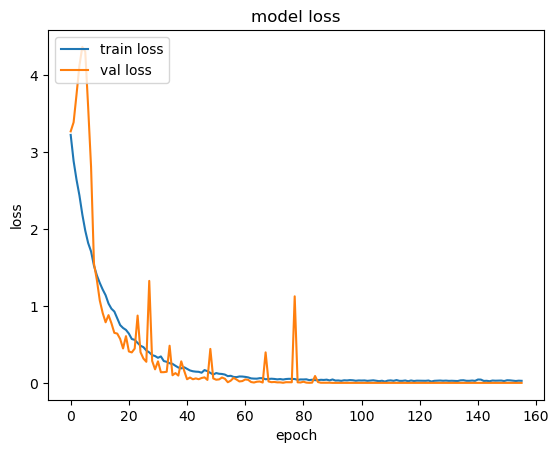

In [70]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

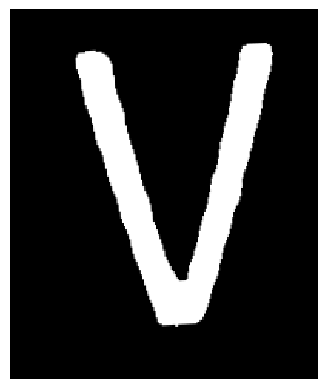

True label (one-hot): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0.]
True label (letter): V
1/1 [==============================] - 0s 77ms/step
Predicted label (letter): V


In [71]:
plt.imshow(test_images[10].squeeze(), cmap='gray')  # squeeze to remove extra dimension
plt.axis('off')
plt.show()

print("True label (one-hot):", test_labels[10])

true_class = np.argmax(test_labels[10])
print("True label (letter):", chr(true_class + 65))

pred = model.predict(np.expand_dims(test_images[10], axis=0))
predicted_class = np.argmax(pred)
print("Predicted label (letter):", chr(predicted_class + 65))


In [55]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print(f"Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")

predictions = model.predict(test_images)

predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

print("Classification Report:\n")
print(classification_report(true_classes, predicted_classes, digits=3))

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            cmap='Blues',
            xticklabels=[chr(i) for i in range(65, 91)],
            yticklabels=[chr(i) for i in range(65, 91)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

ModuleNotFoundError: No module named 'scipy.sparse.linalg'